# System preparation

## Import libraries

In [4]:
#pip install scikit-plot

In [1]:
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
# Data 
import numpy as np
import pandas as pd

#Regular expressions
import re as re

# Utilities
from time import time

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Classification
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score , roc_auc_score

from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve


# Classification algorithms
import xgboost as xgb
from xgboost import XGBClassifier 


# Others
import warnings
from functools import reduce
from pathlib import Path
import os

In [2]:
# Configurations.
%matplotlib inline
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")
plt.rc("font", family="serif", size=15)

# Data preparation

### Load data



Read the csv with the feature engineering applied before to the raw data.

In [3]:
compressors_all_data = pd.read_csv("../data/compressors_all_data_best_features_2days.csv", error_bad_lines=False, index_col=0)

In [4]:
#Make sure the datetime format is correct
compressors_all_data["datetime"] = pd.to_datetime(compressors_all_data["datetime"], format="%Y-%m-%d %H:%M:%S")

In [5]:
compressors_all_data.head()

,compressorID,datetime,cycle,current_mean_3h,rpm_mean_3h,pressure_mean_3h,vibration_mean_3h,current_mean_lag_24h,rpm_mean_lag_24h,pressure_mean_lag_24h,...,s-8760,c-8760,comp1_fail,comp2_fail,comp3_fail,comp4_fail,rul_comp1,rul_comp2,rul_comp3,rul_comp4
0,1,2015-01-01 09:00:00,1,170.028993,449.533798,94.592122,40.893502,NaN,NaN,NaN,...,0.000000,1.000000,0.0,0.0,0.0,0.0,63.875,108.875,NaN,3.875
1,1,2015-01-01 12:00:00,2,164.192565,403.949857,105.687417,34.255891,NaN,NaN,NaN,...,0.002152,0.999998,0.0,0.0,0.0,0.0,63.750,108.750,NaN,3.750
2,1,2015-01-01 15:00:00,3,168.134445,435.781707,107.793709,41.239405,NaN,NaN,NaN,...,0.004304,0.999991,0.0,0.0,0.0,0.0,63.625,108.625,NaN,3.625
3,1,2015-01-01 18:00:00,4,165.514453,430.472823,101.703289,40.373739,NaN,NaN,NaN,...,0.006455,0.999979,0.0,0.0,0.0,0.0,63.500,108.500,NaN,3.500
4,1,2015-01-01 21:00:00,5,168.809347,437.111120,90.911060,41.738542,NaN,NaN,NaN,...,0.008607,0.999963,0.0,0.0,0.0,0.0,63.375,108.375,NaN,3.375


Create lists with the names of the columns for different data:
- Sensors: telemetry information
- Errors: compressor errors and counts
- Maintenance: time since last maintenance
- Model
- Compressor information: Age
- Failures: failures in the different components

## Feature selection

Feature selection is the process of reducing the number of input variables when developing a predictive model. It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

In [6]:
cols_failures_dum = [col for col in compressors_all_data.columns if 'fail' in col]
cols_rul = [col for col in compressors_all_data.columns if 'rul' in col]

In [7]:
predictors = list(compressors_all_data.columns)
predictors = [ele for ele in predictors if ele not in (cols_rul + cols_failures_dum + ['datetime']) ]

In [8]:
target = cols_failures_dum 

In [9]:
X = compressors_all_data[(predictors+target)+ ['datetime']].dropna()
y = compressors_all_data[(predictors+target)+ ['datetime']].dropna()

In [10]:
X = X[predictors+ ['datetime']]
y= y[target+ ['datetime']]

## Model split: Training, Validation and Testing

When working with time series as in this thesis, partitioning in training, validation, and testing must be done carefully to avoid overestimating the performance of the models. 

Predictive models do not have advanced knowledge of future time trends - in practice, such trends are likely to exist and have an adverse impact on model performance. To get an accurate assessment of the performance of a predictive model, it is recommended to perform training on older records and validation / testing using the newer records.

For both reasons, a time-dependent splitting strategy is an excellent choice for predictive maintenance models. The division is done by choosing a point in time according to the desired size of the training and test sets: all the records before the time point are used to train the model, and all the remaining records are used for testing.

In [11]:
# We establish the times corresponding to the records that will be used for training and tests.
threshold_dates = [
    pd.to_datetime("2015-09-30 01:00:00"), pd.to_datetime("2015-10-01 01:00:00")
]

In [12]:
# We make the partition of separate dates.
last_train_date = threshold_dates[0]
first_test_date = threshold_dates[1]

In [13]:
# Typically 20-30% of the data is used.
X_train = X.loc[X["datetime"] < last_train_date]
y_train = y.loc[y["datetime"] < last_train_date]

X_test = X.loc[X["datetime"] > first_test_date]
y_test = y.loc[y["datetime"] > first_test_date]

print(f"{X_train.shape[0]} registers for trainning")
print(f"{X_test.shape[0]} registers for testing")
print(f"{X_test.shape[0] / X_train.shape[0] * 100:0.1f}% of the total data is used for testing")

216700 registers for trainning
73900 registers for testing
34.1% of the total data is used for testing


Check how many failures we have in the train and test

In [14]:
fails_train = y_train[y_train["comp1_fail"] != 0].shape[0]
no_fails_train = y_train[y_train["comp1_fail"] == 0].shape[0]
fails_test = y_test[y_test["comp1_fail"] != 0].shape[0]
no_fails_test = y_test[y_test["comp1_fail"] == 0].shape[0]

print(f"{fails_train / no_fails_train * 100:0.1f}% of the total cases are failures in the train dataset")
print(f"{fails_test / no_fails_test * 100:0.1f}% of the total cases are failures in the test dataset")

1.1% of the total cases are failures in the train dataset
0.9% of the total cases are failures in the test dataset


We see it's crearly an unbalanced problem. For class unbalance problems Get more data. Minor sample of the majority class. SMOTE (Synthetic Minority Over-sampling Technique). Assign weights to minority class.

## Drop Datetime

In [15]:
X.drop('datetime', axis=1,inplace=True)
y.drop('datetime', axis=1,inplace=True)

X_train.drop('datetime',axis=1,inplace=True)
y_train.drop('datetime',axis=1,inplace=True)

X_test.drop('datetime',axis=1,inplace=True)
y_test.drop('datetime',axis=1,inplace=True)

# XGBoost Hyperparameter Tuning

From the comparison before, one of the models with best performance is the XGBoost. We will tune the hyperparameters of the model to boost its performance.

## Finding best hyperparameters

### MVP

In order to compare how the performance of the model will improve, we would use first the default parameters of the CGBClassifier and print some metrics to evaluate the performance

In [19]:
xgb = XGBClassifier(objective='binary:logistic',eval_metric='auc')

In [20]:
# Loop for the different components

for comp in y_train.columns:
  #exec('xgb = xgb_{}'.format(comp))
  xgb.fit(X_train, y_train[comp])
  y_pred = xgb.predict(X_test)
  y_pred_prob = xgb.predict_proba(X_test)
  # view confusion-matrix
  # Print the Confusion Matrix and slice it into four pieces

  from sklearn.metrics import confusion_matrix
  cm = confusion_matrix(y_test[comp], y_pred)
  print(f'Evaluation of {comp}')
  print('Confusion matrix\n\n', cm)
  print('\nTrue Positives(TP) = ', cm[0,0])
  print('\nTrue Negatives(TN) = ', cm[1,1])
  print('\nFalse Positives(FP) = ', cm[0,1])
  print('\nFalse Negatives(FN) = ', cm[1,0])
  print()
  auc = roc_auc_score(y_test[comp], y_pred)
  print(f'AUC = {auc}')
  print()


Evaluation of comp1_fail
Confusion matrix

 [[73068   137]
 [  234   461]]

True Positives(TP) =  73068

True Negatives(TN) =  461

False Positives(FP) =  137

False Negatives(FN) =  234

AUC = 0.8307189478251427

Evaluation of comp2_fail
Confusion matrix

 [[72538   203]
 [  179   980]]

True Positives(TP) =  72538

True Negatives(TN) =  980

False Positives(FP) =  203

False Negatives(FN) =  179

AUC = 0.9213828954927121

Evaluation of comp3_fail
Confusion matrix

 [[73342    87]
 [   62   409]]

True Positives(TP) =  73342

True Negatives(TN) =  409

False Positives(FP) =  87

False Negatives(FN) =  62

AUC = 0.9335901812398238

Evaluation of comp4_fail
Confusion matrix

 [[73114   117]
 [   49   620]]

True Positives(TP) =  73114

True Negatives(TN) =  620

False Positives(FP) =  117

False Negatives(FN) =  49

AUC = 0.9625793343622049



### Randomized search

We print the outputs counts to have an idea of what will our model be predicting. We see a clear unbalance were most of the cases we don't have any failure.

In [21]:
y_train.value_counts()

comp1_fail  comp2_fail  comp3_fail  comp4_fail
0.0         0.0         0.0         0.0           208233
            1.0         0.0         0.0             2598
1.0         0.0         0.0         0.0             2056
0.0         0.0         0.0         1.0             1878
                        1.0         0.0             1423
            1.0         0.0         1.0              176
1.0         1.0         0.0         0.0              112
0.0         1.0         1.0         0.0               64
1.0         0.0         0.0         1.0               64
0.0         0.0         1.0         1.0               48
1.0         0.0         1.0         0.0               48
dtype: int64

**The XGBClassifier hyperparameters that will be used are:**


* learning_rate => Learning rate used for reducing the gradient step.

* max_depth => Control max depth of each trained tree.
* subsample =>  Percentage of rows used per tree building iteration

* scale_pos_weight => number of negative samples / number of positive samples

In [16]:
# A parameter grid for XGBoost
params={ 'learning_rate': np.arange(0.01, 0.5, 0.05),
         'max_depth': np.arange(3, 10, 2),
         'subsample': np.arange( 0.2, 1, 0.3),  
         'scale_pos_weight': [1, 20, 50, 100, 500]}

**Parameters to set as default in the XGB Classifier.**

Specify the learning task and the corresponding learning objective.
- binary:logistic: logistic regression for binary classification, output probability

Evaluation metrics for validation data.eval_metric
- aucpr: Area under the PR curve. Available for binary classification and learning-to-rank tasks.

In [17]:
# fit model no training data
xgb_classifier=XGBClassifier(objective = 'binary:logistic',
                             use_label_encoder =False, 
                             eval_metric='aucpr',
                             n_jobs=-1)


In [18]:
folds = 5

In [19]:
stf_kf=StratifiedKFold(n_splits=folds)

We search the best model based on the ROC AUC metric

In [20]:
rs_cv_classifier=RandomizedSearchCV(xgb_classifier,
                                    param_distributions=params,
                                    cv=stf_kf,
                                    scoring='roc_auc',
                                    n_jobs=-1)

In [21]:
for comp in y_train:
  # execute search
  start_time = time()

  rs_cv_classifier.fit(X_train,y_train[comp])

  rs_cv_time = time() - start_time

  y_pred=rs_cv_classifier.predict(X_test)


  print(f"Best Parameter for {comp}: \n",rs_cv_classifier.best_params_)
  print(f"Total time {rs_cv_time}")

  cm = confusion_matrix(y_test[comp], y_pred)
  print('Confusion matrix\n\n', cm)
  print('\nTrue Positives(TP) = ', cm[0,0])
  print('\nTrue Negatives(TN) = ', cm[1,1])
  print('\nFalse Positives(FP) = ', cm[0,1])
  print('\nFalse Negatives(FN) = ', cm[1,0])
  print()
  auc = roc_auc_score(y_test[comp], y_pred)
  print(f'AUC = {auc}')
  print()

Best Parameter for comp1_fail: 
 {'subsample': 0.2, 'scale_pos_weight': 100, 'max_depth': 5, 'learning_rate': 0.11}
Total time 831.523818731308
Confusion matrix

 [[72727   478]
 [  100   595]]

True Positives(TP) =  72727

True Negatives(TN) =  595

False Positives(FP) =  478

False Negatives(FN) =  100

AUC = 0.9247927496401894

Best Parameter for comp2_fail: 
 {'subsample': 0.5, 'scale_pos_weight': 100, 'max_depth': 5, 'learning_rate': 0.060000000000000005}
Total time 784.6266329288483
Confusion matrix

 [[72008   733]
 [   33  1126]]

True Positives(TP) =  72008

True Negatives(TN) =  1126

False Positives(FP) =  733

False Negatives(FN) =  33

AUC = 0.9807251653036512

Best Parameter for comp3_fail: 
 {'subsample': 0.8, 'scale_pos_weight': 1, 'max_depth': 3, 'learning_rate': 0.46}
Total time 714.4464979171753
Confusion matrix

 [[73346    83]
 [   52   419]]

True Positives(TP) =  73346

True Negatives(TN) =  419

False Positives(FP) =  83

False Negatives(FN) =  52

AUC = 0.94423

## Best hyperparameters

We collect in a table the outputs from the Random Search in the previous step

HyperParameter | Component 1 | Component 2 | Component 3 | Component 4  
--- | --- | --- | --- | ---
learning_rate | 0.11 | 0.06 | 0.21 | 0.26
max_depth | 5 | 5 | 5 | 3
subsamble| 0.2 | 0.5 | 0.8 | 0.5
scale_pos_weight | 100 | 100 | 100 | 20

In [27]:
xgb_comp1_fail = XGBClassifier(learning_rate=0.11,
                                max_depth=5,
                                subsample = 0.2,
                                scale_pos_weight = 100,
                                objective = 'binary:logistic',
                                use_label_encoder =False, 
                                eval_metric='aucpr')

In [28]:
xgb_comp2_fail = XGBClassifier(learning_rate=0.06,
                                max_depth=5,
                                subsample = 0.5,
                                scale_pos_weight = 100,
                                objective = 'binary:logistic',
                                use_label_encoder =False, 
                                eval_metric='aucpr')

In [29]:
xgb_comp3_fail = XGBClassifier(learning_rate=0.21,
                                max_depth=5,
                                subsample = 0.8,
                                scale_pos_weight = 100,
                                objective = 'binary:logistic',
                                use_label_encoder =False, 
                                eval_metric='aucpr')

In [30]:
xgb_comp4_fail = XGBClassifier(learning_rate=0.26,
                                max_depth=3,
                                subsample = 0.5,
                                scale_pos_weight = 20,
                                objective = 'binary:logistic',
                                use_label_encoder =False, 
                                eval_metric='aucpr')

#### Report

We create a report with the classification metrics for the models built in the previous step.

- ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.

- Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.

- ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.

Evaluation of comp1_fail

Confusion matrix

 [[72727   478]
 [  100   595]]

True Positives(TP) =  72727

True Negatives(TN) =  595

False Positives(FP) =  478

False Negatives(FN) =  100

AUC = 0.9247927496401894

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     73205
         1.0       0.55      0.86      0.67       695

    accuracy                           0.99     73900
   macro avg       0.78      0.92      0.83     73900
weighted avg       0.99      0.99      0.99     73900



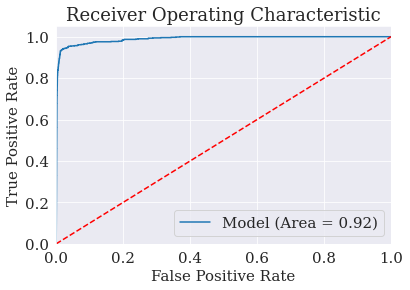

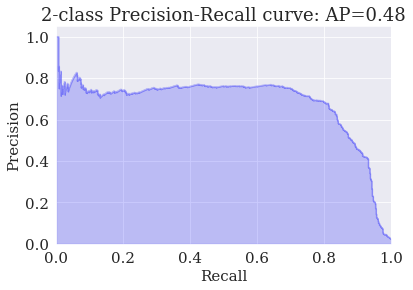


Evaluation of comp2_fail

Confusion matrix

 [[72008   733]
 [   33  1126]]

True Positives(TP) =  72008

True Negatives(TN) =  1126

False Positives(FP) =  733

False Negatives(FN) =  33

AUC = 0.9807251653036512

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     72741
         1.0       0.61      0.97      0.75      1159

    accuracy                           0.99     73900
   macro avg       0.80      0.98      0.87     73900
weighted avg       0.99      0.99      0.99     73900



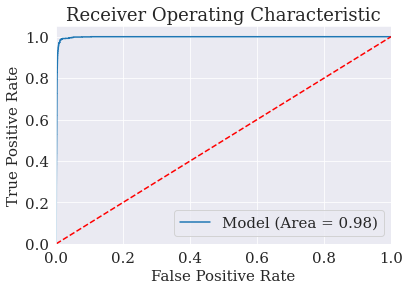

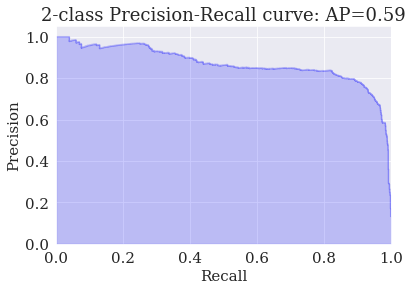


Evaluation of comp3_fail

Confusion matrix

 [[73340    89]
 [   40   431]]

True Positives(TP) =  73340

True Negatives(TN) =  431

False Positives(FP) =  89

False Negatives(FN) =  40

AUC = 0.9569311273981057

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     73429
         1.0       0.83      0.92      0.87       471

    accuracy                           1.00     73900
   macro avg       0.91      0.96      0.93     73900
weighted avg       1.00      1.00      1.00     73900



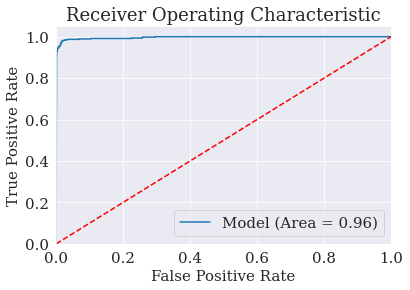

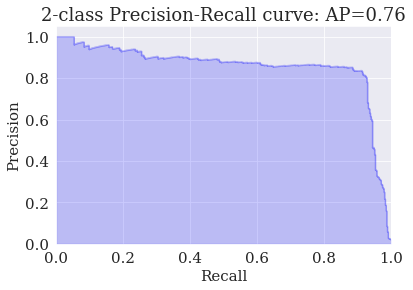


Evaluation of comp4_fail

Confusion matrix

 [[73043   188]
 [   33   636]]

True Positives(TP) =  73043

True Negatives(TN) =  636

False Positives(FP) =  188

False Negatives(FN) =  33

AUC = 0.9740527134695648

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     73231
         1.0       0.77      0.95      0.85       669

    accuracy                           1.00     73900
   macro avg       0.89      0.97      0.93     73900
weighted avg       1.00      1.00      1.00     73900



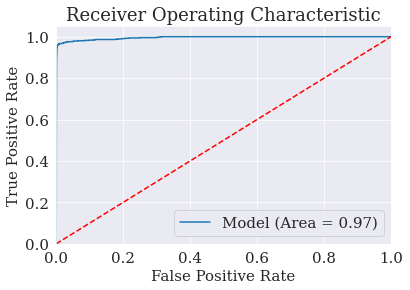

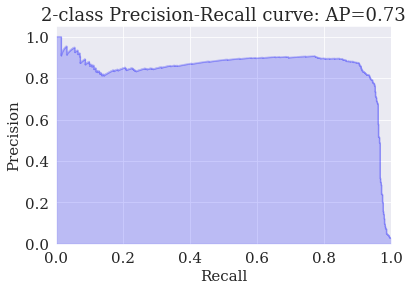

In [31]:
# Loop for the different components

for comp in y_train.columns:
  exec('xgb_temp = xgb_{}'.format(comp))
  xgb_temp.fit(X_train, y_train[comp])
  y_pred = xgb_temp.predict(X_test)
  y_pred_prob = xgb_temp.predict_proba(X_test)[:,1]

  # view confusion-matrix
  # Print the Confusion Matrix and slice it into four pieces

  cm = confusion_matrix(y_test[comp], y_pred)
  print(f'Evaluation of {comp}')
  print()
  print('Confusion matrix\n\n', cm)
  print('\nTrue Positives(TP) = ', cm[0,0])
  print('\nTrue Negatives(TN) = ', cm[1,1])
  print('\nFalse Positives(FP) = ', cm[0,1])
  print('\nFalse Negatives(FN) = ', cm[1,0])
  print()
  auc = roc_auc_score(y_test[comp], y_pred)
  print(f'AUC = {auc}')
  print()

  # Report
  print(classification_report(y_test[comp], y_pred))

  # Calculate area under the curve (logit_roc_auc)
  logit_roc_auc = roc_auc_score(y_test[comp], y_pred) 
  # Plot ROC
  fpr, tpr, thresholds = roc_curve(y_test[comp], y_pred_prob) 
  plt.figure()
  plt.plot(fpr, tpr, label='Model (Area = %0.2f)' % logit_roc_auc) 
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  #plt.savefig(f'XGBoost_ROC_{comp}')
  plt.show()

  # Get average precision
  average_precision = average_precision_score(y_test[comp], y_pred)
  # Plot PR
  precision, recall, _ = precision_recall_curve(y_test[comp], y_pred_prob)
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title(f'2-class Precision-Recall curve: AP={average_precision:.2f}')
  #plt.savefig(f'XGBoost_PR_{comp}')
  plt.show()

  print()


# Save the best models

Let's define the hyperparameters of the models to be saved.
The whole dataset will be used to fit the model and enrich both from the training and testing data.


In [32]:
for comp in y_train.columns:
  exec('xgb_temp = xgb_{}'.format(comp))
  xgb_temp.fit(X, y[comp])
  xgb_temp.save_model(f"xgb_model_{comp}.model")